To be run in CMSSW_10_2_3 with adding:
pip install --user joblib scikit-learn==0.20.4

Like v2 but with BTD trained in signal region

# Imports

In [1]:
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

In [49]:
from __future__ import print_function

import h5py, os, sys, glob, datetime, time
sys.path.append('../lib')
from glob import glob
import numpy as np
import scipy as sp
from scipy.special import erf

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
from matplotlib.colors import LogNorm

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import joblib
import pickle
from prettytable import PrettyTable
import ROOT as rt
rt.PyConfig.IgnoreCommandLineOptions = True
rt.gROOT.SetBatch()
rt.gErrorIgnoreLevel = rt.kError

from histo_utilities import create_TH2D, create_TH1D, create_Canvas, make_effiency_plot, rootTH1_to_np
from progressBar import ProgressBar
from cebefo_style import cebefo_style

cebefo_style()


dnd = []

In [50]:
print glob.__file__

SyntaxError: invalid syntax (<ipython-input-50-a7979b3d772e>, line 1)

In [3]:
# Thong's DNN imports
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, Lambda
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

Using TensorFlow backend.


In [4]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# Function Definitions

In [5]:
Mjj_selection = 1100.

SM_eff = 1e-2

loss_scaling = 1.0
Mjj_scaling = 2000.0

def scaleDownMjj(x):
    return (x-2*Mjj_selection)/Mjj_scaling

def computeDiscriminatingVar_sum(x):
    out = x[:,-6]+x[:,-3]
    out *= loss_scaling #1e9
    return out

def computeDiscriminatingVar_str_sum(l1, l2):
    out = loss_scaling*(l1+l2)
    return out

def computeDiscriminatingVar_min(x):
    out = np.minimum(x[:,-6],x[:,-3])
    out *= loss_scaling #1e9
    return out

def computeDiscriminatingVar_str_min(l1, l2):
    out = loss_scaling*np.minimum(l1,l2)
    return out


# set loss strategy to be used
computeDiscriminatingVar = computeDiscriminatingVar_min
computeDiscriminatingVar_str = computeDiscriminatingVar_str_min

In [6]:
def plot_hist( data, xlabel, ylabel, title, plotname='', legend=[], ylogscale=True ):
    fig = plt.figure( )
    plot_hist_on_axis( plt.gca(), data, xlabel, ylabel, title, legend, ylogscale )
    if legend:
        plt.legend()
    plt.tight_layout()
    fig.savefig('fig/' + plotname + '_hist.png')
    plt.close()


def plot_hist_on_axis( ax, data, xlabel, ylabel, title, legend=[], ylogscale=True ):
    bin_num = 70
    alpha = 0.85
    if ylogscale:
        ax.set_yscale('log', nonposy='clip')
    ax.hist( data, bins=bin_num, normed=True, alpha=alpha, histtype='stepfilled', label=legend )
    ax.set_ylabel( ylabel )
    ax.set_xlabel( xlabel )
    ax.set_title( title, fontsize=10 )
    ax.tick_params(axis='both', which='minor', labelsize=8)
    #ax.set_ylim(bottom=1e-7)



In [7]:
def plot_hist_2d( x, y, xlabel, ylabel, title, plotname=''):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.gca()
    im = plot_hist_2d_on_axis( ax, x, y, xlabel, ylabel, title )
    fig.colorbar(im[3])
    plt.tight_layout()
    fig.savefig('fig/' + plotname + '_hist_2d.png')
    plt.close()
    #plt.draw()

def plot_hist_2d_on_axis( ax, x, y, xlabel, ylabel, title ):
    im = ax.hist2d(x, y, bins=100, norm=colors.LogNorm())
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_ylim(top=70.)
    return im 

In [8]:
def read_in_data( file_dir ):
    maxEvts = int(1e6)
    pb = ProgressBar(maxEvts)

    data = None
    labels = None
    flist = glob(file_dir + '/' + '*result.h5')
    #print(flist)
    i_file = 0
    for i_file, fname in enumerate(flist):
        f = h5py.File(fname, 'r')
        #print(f.keys())
        aux_evts = np.array(f.get('results'))
        aux_evts = aux_evts[aux_evts[:,0] > Mjj_selection]
        if data is None:
            labels = list(f.get('labels'))
            print('Labels:')
            print(labels)
            pb.show(0)
            data = aux_evts
        else:
            data = np.append(data, aux_evts, axis=0)

        pb.show(data.shape[0])

        if data.shape[0] > maxEvts:
            break


    N_evts = (i_file+1) * 10000 # ??? data_train.shape[0]#
    print('\nnum files read in dir ', file_dir, ': ', i_file+1)
    return [ data, labels, N_evts ] 

# Get the qcd sample for trainig

In [9]:
#file_dir = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/AE_Score/'
base_dir = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/weighted_samples'#'/afs/cern.ch/work/k/kiwoznia/vae_results' #/results_before_max_pixel'
file_dir = base_dir + '/qcd_sqrtshatTeV_13TeV_PU40'
#file_dir = '/afs/cern.ch/work/k/kiwoznia/vae_results/qcd_sqrtshatTeV_13TeV_PU40_SIDEBAND'
data_train, labels, N_evts = read_in_data( file_dir )
print("\nnum evts according to docs: ", N_evts)
QCD_xsec = 8.73e-6 #mb
QCD_xsec *= 1e9 #fb # ??????
print('\nLuminosity used for training')
print('{:.2} fb^-1'.format(N_evts/QCD_xsec))
        

Labels:
['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss', 'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss']
[###################-]  98% - ETA:    2 s   
num files read in dir  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/weighted_samples/qcd_sqrtshatTeV_13TeV_PU40 :  1863

num evts according to docs:  18630000

Luminosity used for training
2.1e+03 fb^-1


In [10]:
print('num events read ', data_train.shape[0])

num events read  1000716


In [11]:
#pickle.dump(data_train, open('data/tmp_qcd_sqrtshatTeV_13TeV_PU40.pkl', 'wb'))

In [12]:
#data_train = pickle.load(open('data/tmp_qcd_sqrtshatTeV_13TeV_PU40.pkl', 'rb'))

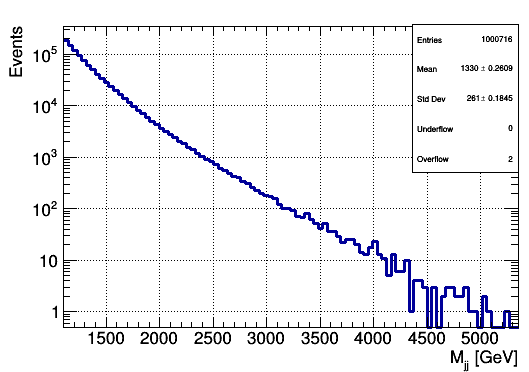

In [13]:
c = create_Canvas(size=(int(800/1.5),int(600/1.5)))
h_Mjj_train = create_TH1D(data_train[:,0], title='', axis_title = ['M_{jj} [GeV]','Events'], 
                binning=[100, Mjj_selection, 0.8*np.max(data_train[:,0])])

h_Mjj_train.Draw()
c.SetLogy()
c.Draw()

### Train the model to predict the cut

# DNN for quantile regression

In [14]:
def quantile_loss(target, pred):
    alpha = 1 - SM_eff
    err = target - pred
    return K.tf.where(err>=0, alpha*err, (alpha-1)*err)

inputs = Input(shape=(1,))
hidden = Dense(100, activation='relu')(inputs)
hidden = Dense(100, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(1)(hidden)
model = Model(inputs, output)
model.compile(loss=quantile_loss, optimizer=Adam(lr=1e-4))
model.summary()

x = np.reshape(data_train[:,0], (-1,1))
y = computeDiscriminatingVar(data_train)
print(x.shape)
print(y.shape)

model.fit(scaleDownMjj(x), y, epochs=100, batch_size=10000, 
        verbose=1, validation_split=0.2, shuffle=True,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1),ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)])

date = datetime.date.today()
date_str = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
#model.save('cut_models/dnn_cut_trained_{}.h5'.format(date_str))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total para

2020-01-10 11:31:01.751189: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [15]:
# Compute weights to make it mass agnostic
# hM = h_Mjj_train.Clone('hM')
# print(hM.FindBin(10000))
# scale = np.sqrt(hM.GetMaximum()*hM.GetMinimum(0))
# print(scale)
# hM.Scale(1./scale)

# weights = np.ones_like(data_train[:,0])
# for i, m in enumerate(data_train[:,0]):
#     weights[i] = 1./hM.GetBinContent(hM.FindBin(m))
#     if i%1000000 == 0:
#         print(i)

In [16]:
#gbr_cut = GradientBoostingRegressor(loss='quantile', alpha=1-SM_eff,
#                                n_estimators=250, max_depth=3,
#                                learning_rate=.05, min_samples_leaf=30,
#                                min_samples_split=30,
#                                validation_fraction=0.5,
#                                n_iter_no_change=5,
#                                tol=1e-5,
#                                verbose=2)

In [17]:
#x = np.reshape(data_train[:,0], (-1,1))
#y = computeDiscriminatingVar(data_train)
#gbr_cut = joblib.load('cut_models/gbr_cut_trained_20191028_pval0p5947.joblib','r')
#gbr_cut.fit(x, y, sample_weight=None);

#date = datetime.date.today()
#date_str = '{}{:02d}{:02d}'.format(date.year, date.month, date.day)
#joblib.dump(gbr_cut, '../models/gbr_cut_trained_{}.joblib'.format(date_str)) 

((880.0, 5544.292314651795), (0.022879447747728716, 0.41708277990216314))


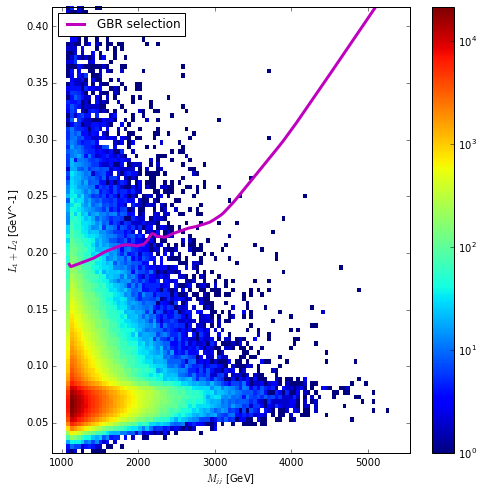

In [31]:
x = np.reshape(data_train[:,0], (-1,1))
plt.figure(figsize=(8, 8))
x_min = Mjj_selection*0.8
x_max = np.percentile(x, 99.9999)
#x_max = np.max(x)
print(((x_min , x_max), (np.min(y), np.percentile(y, 1e2*(1-1e-4)))))
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.percentile(y, 1e2*(1-1e-4)))), 
           norm=LogNorm(), bins=100,
           label='signal data'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
plt.plot(xs, model.predict( np.reshape(scaleDownMjj(xs), (-1,1)) ), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('$L_1 + L_2$ [GeV^-1]')
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.legend(loc='best')
plt.draw()

In [32]:
#joblib.dump(gbr_cut, 'cut_models/gbr_cut_trained_{}.joblib'.format(date_str)) 

In [33]:
model.save('cut_models/dnn_cut_trained_{}.h5'.format(date_str))

In [34]:
# from keras.models import load_model
# model = load_model('cut_models/dnn_cut_trained_20191030.h5')

In [35]:
def getSelection(x_Mjj, x_loss):
    cut = model.predict(np.reshape(x_Mjj, (-1,1)))
    return x_loss > cut.flatten()

In [36]:
def plotMassSpectrum(mJJ_pass, mJJ_rej, title=''):
    h_a = create_TH1D(mJJ_pass, 
                      name='h_acc', title='Accepted',
                      binning=binning,
                      opt='overflow'
                     )
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_r = create_TH1D(mJJ_rej, 
                      name='h_rej', title='Rejected',
                      axis_title=['M_{jj} [GeV]', 'Events'],
                      binning=binning,
                      opt='overflow'
                     )
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-4, 0.2], draw_opt = 'E', title=title)
    c.pad1.SetLogy()
    c.pad2.SetLogy()

    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(8)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)

    c.Draw()
    return c

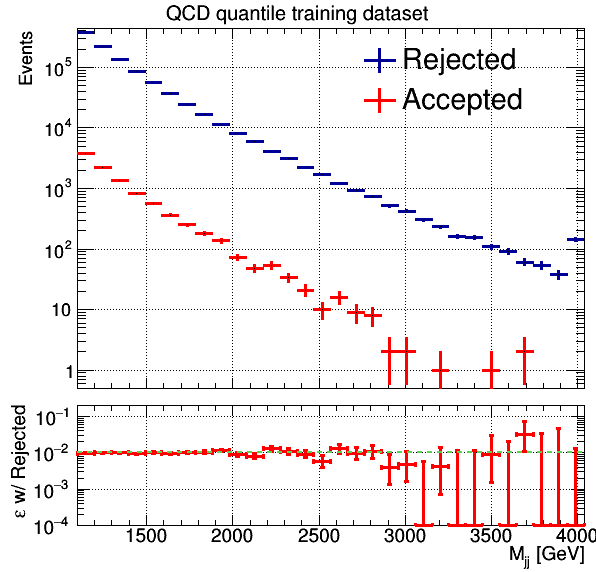

In [37]:
x = x.flatten()
binning=[30, Mjj_selection, np.percentile(x, 99.99)]

sel = getSelection(scaleDownMjj(x), y)

c = plotMassSpectrum(x[sel], x[np.logical_not(sel)], 'QCD quantile training dataset')
h_a = c.h_list[1]
h_r = c.h_list[0]

# Define and test Hypotesis test

In [38]:
def HypotesisTets(h_a_bin_content, h_r_bin_content, eff, N_asymov = 10000, max_N_asymov = 1e7, show_hist=True):
    nu = eff*h_r_bin_content/(1-eff)

    probs_obs = sp.stats.poisson.pmf(h_a_bin_content.astype(np.int), nu)
    probs_obs = np.where(probs_obs < 1e-10, np.full_like(probs_obs, 1e-10), probs_obs)
    s_obs = np.sum(-np.log(probs_obs), axis=-1)
    print('S obs:', s_obs)

    N_worse = 0
    N_tot = 0
    loops = 0
    while N_worse < 25 and N_tot < max_N_asymov:
        loops += 1
        if loops > 1 and loops%10 == 0:
            print(N_tot, N_worse)
        if loops == 10:
            print('Increasing by a factor 5 the number of asymov per loop')
            N_asymov *=5
        o_asymov = np.random.poisson(nu, (N_asymov, nu.shape[0]))
        probs = sp.stats.poisson.pmf(o_asymov, nu)
        probs = np.where(probs < 1e-10, np.full_like(probs, 1e-10), probs)
        nll = -np.log(probs)
        s_asymov = np.sum(nll, axis=-1)

        N_worse += np.sum(s_asymov > s_obs)
        N_tot += N_asymov

        if max_N_asymov/N_tot < 25 and (N_worse * (max_N_asymov/N_tot) < 25):
            print('Will never have enough stat - giving up.')
            p_val = max(1, N_worse)/float(N_tot)
            return p_val

    print('Test stat reached after {} loops'.format(loops))

    p_val = max(1, N_worse)/float(N_tot)
    
    if show_hist:
        plt.figure()
        binContent, _, _ = plt.hist(s_asymov, label='Distribution assuming eff={:.1f}%'.format(100*eff))
        plt.plot([s_obs, s_obs], [0,np.max(binContent)], label='Observed')
        plt.legend(loc='best')
        plt.xlabel('Test statistic')
        plt.ylabel('Entries')

    return p_val

S obs: 88.16215112565976
Test stat reached after 1 loops


0.3108

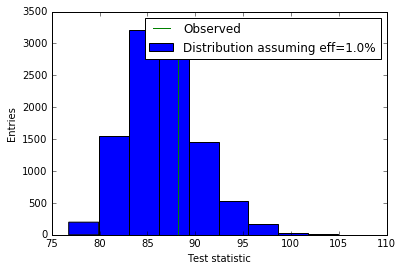

In [39]:
h_a_bin_content, _ = rootTH1_to_np(h_a)
h_r_bin_content, _ = rootTH1_to_np(h_r)
HypotesisTets(h_a_bin_content, h_r_bin_content, SM_eff, N_asymov=10000)

# Analyze signal region

In [40]:
#base_dir = '/afs/cern.ch/work/k/kiwoznia/vae_results/results_before_max_pixel'
base_dir = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/weighted_samples' #'/afs/cern.ch/work/k/kiwoznia/vae_results' # /results_before_max_pixel


sample_loc = {'qcdSigExt': base_dir + '/qcd_sqrtshatTeV_13TeV_PU40_EXT_ALL',  #_ALL # _ext + _ext2
              'GtoWW1': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV',
              'GtoWW2': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_2.5TeV',
              'GtoWW3': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_3.5TeV',
              'GtoWW4': base_dir + '/RSGraviton_WW_NARROW_13TeV_PU40_4.5TeV',
              'AtoHZ': base_dir + '/AtoHZ_to_ZZZ_13TeV_PU40/',
              'GtoTTBroad': base_dir + '/RSGraviton_tt_BROAD_13TeV_PU40',
              'GtoTTNarr': base_dir + '/RSGraviton_tt_NARROW_13TeV_PU40'
             }

sample_label = {'qcdSigExt':r'QCD signal',
                'GtoWW1':r'$G(1.5 TeV)\to WW$',
                'GtoWW2':r'$G(2.5 TeV)\to WW$',
                'GtoWW3':r'$G(3.5 TeV)\to WW$',
                'GtoWW4':r'$G(4.5 TeV)\to WW$',
                'AtoHZ':r'$A \to HZ \to ZZZ$',
                'GtoTTBroad':r'$G \to TT broad$',
                'GtoTTNarr':r'$G \to TT narrow$'
               }

sample_label_ROOT = {'qcdSigExt':'QCD signal',
                'GtoWW1':'G(1.5 TeV) to WW$',
                'GtoWW2':'$G(2.5 TeV) to WW$',
                'GtoWW3':'$G(3.5 TeV) to WW$',
                'GtoWW4':'$G(4.5 TeV) to WW$',
                'AtoHZ':'A to HZ to ZZZ',
                'GtoTTBroad':'G to TT broad',
                'GtoTTNarr':'G to TT narrow'
               }

SM_samples = ['qcdSigExt']
BSM_samples = ['GtoWW1', 'GtoWW2', 'GtoWW3', 'GtoWW4','AtoHZ','GtoTTBroad', 'GtoTTNarr']

sample_nGenEvts = {'qcdSigExt': (3826+2873)*10000, # TODO: adapt numbers! 
                   'GtoWW1': 99*10000,
                   'GtoWW2': 92*10000,
                   'GtoWW3': 92*10000,
                   'GtoWW4': 97*10000,
                   'AtoHZ': 98*1000,
                   'GtoTTBroad': 98*1000,
                   'GtoTTNarr': 96*1000
                  }

sample_xsec = {'qcdSigExt': 8734.0 #pb
              }

In [41]:
lumi_generated = sample_nGenEvts['qcdSigExt']/sample_xsec['qcdSigExt']
print('Lumi: {:.1f} pb^-1'.format(lumi_generated))

Lumi: 7670.0 pb^-1


### Get the data

In [42]:
result_data = {}
data = {}
sample_eff = {}
table = PrettyTable()
table.field_names = ['Sample', 'Trg evts', 'Eff. trg [%]', 'VAE sel. evts', 'Eff VAE [%]']

In [43]:
# read in data
labels = None
for n, file_dir in sample_loc.iteritems():
    print(n)
    sample, labels, N_evts = read_in_data( file_dir )
    result_data[n] = sample


qcdSigExt
Labels:
['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss', 'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss']
[###################-]  99% - ETA:    1 s   
num files read in dir  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/weighted_samples/qcd_sqrtshatTeV_13TeV_PU40_EXT_ALL :  3229
GtoTTBroad
Labels:
['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss', 'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss']
[#-------------------]  6% - ETA:   95 s   
num files read in dir  /eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/weighted_samples/RSGraviton_tt_BROAD_13TeV_PU40 :  98
GtoTTNarr
Labels:
['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss', 'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss']
[--------------------]  4% - ETA:  129 s   
nu

In [44]:
print(labels)

['mJJ', 'j1Pt', 'j1Eta', 'j1Phi', 'j1M', 'j1E', 'j2Pt', 'j2M', 'j2E', 'DeltaEtaJJ', 'DeltaPhiJJ', 'j1TotalLoss', 'j1RecoLoss', 'j1KlLoss', 'j2TotalLoss', 'j2RecoLoss', 'j2KlLoss']


In [45]:
# compute discriminating var and selection for data, print in table
for n, file_dir in sample_loc.iteritems():
    x = result_data[n]
    dVar = computeDiscriminatingVar(x)
    sel = getSelection(scaleDownMjj(x[:,0]), dVar)
    x = np.column_stack((x, dVar, sel))
    print(x.shape[0])
    sample_eff[n] = float(x.shape[0])/sample_nGenEvts[n]

    dt = [(str(s), '<f4') for s in labels + ['dVar']]
    dt += [('sel', '?')]
    data[n] = np.array(list(zip(*x.T)), dtype=dt)
    
    eff = '{:.2f}'.format(100.0*np.sum(data[n]['sel'])/float(data[n]['sel'].shape[0]))
    table.add_row([n, data[n]['sel'].shape[0], '{:.1f}'.format(100.0*sample_eff[n]), np.sum(data[n]['sel']), eff])

print(table)

1000095
64822
63572
585624
63128
371292
474653
518954
+------------+----------+--------------+---------------+-------------+
|   Sample   | Trg evts | Eff. trg [%] | VAE sel. evts | Eff VAE [%] |
+------------+----------+--------------+---------------+-------------+
| qcdSigExt  | 1000095  |     1.5      |      9652     |     0.97    |
| GtoTTBroad |  64822   |     66.1     |      7093     |    10.94    |
| GtoTTNarr  |  63572   |     66.2     |      6956     |    10.94    |
|   GtoWW4   |  585624  |     60.4     |     33980     |     5.80    |
|   AtoHZ    |  63128   |     64.4     |      6131     |     9.71    |
|   GtoWW1   |  371292  |     37.5     |     32862     |     8.85    |
|   GtoWW2   |  474653  |     51.6     |     57826     |    12.18    |
|   GtoWW3   |  518954  |     56.4     |     43563     |     8.39    |
+------------+----------+--------------+---------------+-------------+


In [51]:
for n, label in sample_label.iteritems():
    x = data[n]
    y = computeDiscriminatingVar_str(x['j1TotalLoss'],x['j2TotalLoss'])
    plot_hist_2d(x['mJJ'],y, 'mass jj', 'L1+L2', 'mass vs loss ' + label, n)


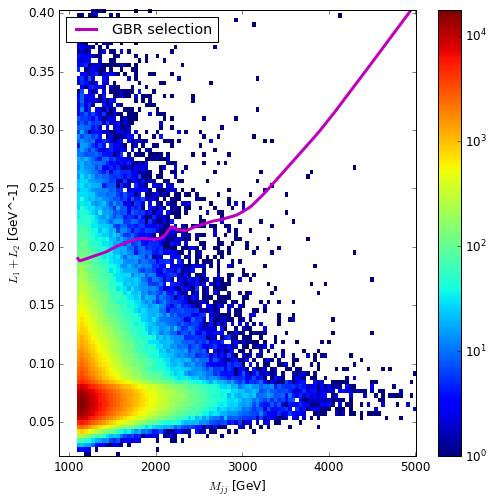

In [54]:
x = np.reshape(data['qcdSigExt']['mJJ'], (-1,1))
y = computeDiscriminatingVar_str(data['qcdSigExt']['j1TotalLoss'], data['qcdSigExt']['j2TotalLoss'])

plt.figure(figsize=(8, 8))
x_min = Mjj_selection*0.8
x_max = np.percentile(x, 99.999)
plt.hist2d(x[:,0], y,
           range=((x_min , x_max), (np.min(y), np.percentile(y, 1e2*(1-1e-4)))), 
           norm=LogNorm(), bins=100,
           label='qcd signal ext'
          )

xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
plt.plot(xs, model.predict(np.reshape(scaleDownMjj(xs), (-1,1))), '-', color='m', lw=3, label='GBR selection')

plt.ylabel('$L_1 + L_2$ [GeV^-1]')
plt.xlabel('$M_{jj}$ [GeV]')
plt.colorbar()
plt.legend(loc='best')
plt.draw()

### Define utilitities

In [55]:
def plotMassSpectrum_wSig(h_r, h_a, h_a_sig, name_BSM, lumi_text, p_val):
    h_r.GetYaxis().SetRangeUser(0.5, 1.2*h_r.GetMaximum())
    h_r.SetStats(0)
    h_r.Sumw2()
    h_r.SetLineWidth(2)
    
    h_a.SetLineColor(2)
    h_a.SetStats(0)
    h_a.Sumw2()
    h_a.SetLineWidth(2)
    
    h_a_sig.SetFillStyle(3001)
    h_a_sig.SetFillColor(8)
    h_a_sig.SetLineWidth(0)

    c = make_effiency_plot([h_r, h_a], ratio_bounds=[1e-3, None], draw_opt = 'E')
    c.pad1.SetLogy()
    c.pad1.cd()
    h_a_sig.Draw('SAME')
    c.leg.AddEntry(h_a_sig, 'Acc. '+sample_label_ROOT[name_BSM], 'f')
    
    latex = rt.TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextAlign(31)
    t = c.pad1.GetTopMargin()
    r = c.pad1.GetRightMargin()
    latex.DrawLatex(1-r, 1-0.85*t, lumi_text)

    c.pad2.SetLogy()
    c.pad2.cd()
    c.ln = rt.TLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    c.ln.SetLineWidth(2)
    c.ln.SetLineStyle(7)
    c.ln.SetLineColor(6)
    c.ln.DrawLine(h_r.GetXaxis().GetXmin(), SM_eff, h_r.GetXaxis().GetXmax(), SM_eff)
    
    latex.SetTextSize(0.1)
    latex.SetTextAlign(13)
    l = c.pad2.GetLeftMargin()
    t = c.pad2.GetTopMargin()
    latex.DrawLatex(l*1.1, 1-2*t, 'p-value: {:.1f} %'.format(100*p_val))

    c.Draw()
    return c

## Find the p-value as a function of xsec

In [56]:
lumi = 2000 #pb^-1

N_asymov = 10000
N_exp_per_xsec = 5

In [57]:
dic_p_val = {}
rt.gROOT.SetBatch(True)



GtoWW1
xsec BSM 1.0e-05 pb
Experiment: 0
S obs: 71.76789081154686
Test stat reached after 1 loops
Experiment: 1
S obs: 68.50130077462038
Test stat reached after 1 loops
Experiment: 2
S obs: 64.44565760038797
Test stat reached after 1 loops
Experiment: 3
S obs: 63.72870164314213
Test stat reached after 1 loops
Experiment: 4
S obs: 69.98871355149497
Test stat reached after 1 loops
xsec BSM 1.0e-04 pb
Experiment: 0
S obs: 74.82162831231169
Test stat reached after 1 loops
Experiment: 1
S obs: 65.70134892696835
Test stat reached after 1 loops
Experiment: 2
S obs: 67.22077115791653
Test stat reached after 1 loops
Experiment: 3
S obs: 66.97318399226663
Test stat reached after 1 loops
Experiment: 4
S obs: 64.68561720966088
Test stat reached after 1 loops


GtoWW2
xsec BSM 1.0e-05 pb
Experiment: 0
S obs: 67.87343766794666
Test stat reached after 1 loops
Experiment: 1
S obs: 65.47127433767298
Test stat reached after 1 loops
Experiment: 2
S obs: 67.31189972535083
Test stat reached after 1 loops

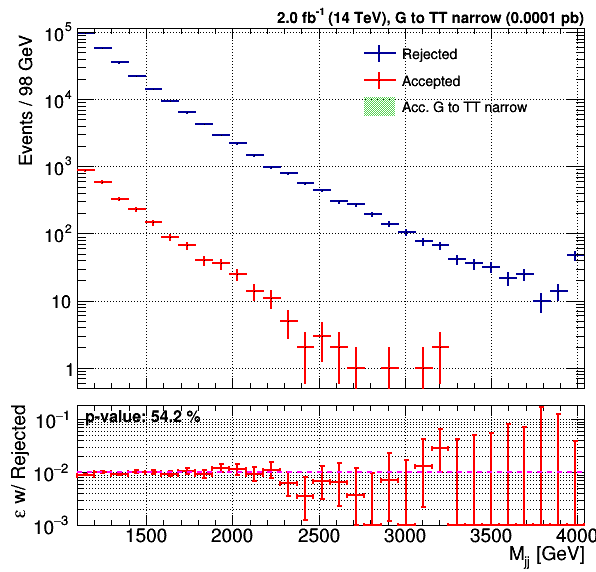

In [58]:
for name_BSM in BSM_samples:
    print('\n\n'+name_BSM)
    dic_p_val[name_BSM] = []
    for xsec_BSM in np.logspace(-5, -4, 2): 
        print('xsec BSM {:.1e} pb'.format(xsec_BSM))
        lumi_text = '{:.1f} fb^{{-1}} (14 TeV), '.format(1e-3*lumi) + sample_label_ROOT[name_BSM] + ' ({:.2} pb)'.format(xsec_BSM)

        p_val_test = []
        for i_exp in range(N_exp_per_xsec):
            print('Experiment:', i_exp)
            d_obs = np.zeros((0,2))

            sample_xsec[name_BSM] = xsec_BSM
            for n in SM_samples + [name_BSM]:
                nExpEvts = lumi*sample_xsec[n]*sample_eff[n]
                nEvts = np.random.poisson(nExpEvts)
                if data[n]['mJJ'].shape[0] < nEvts:
                    print('[WARNING] ' + n + ' re-use factor = {:.2f}'.format(float(nEvts)/data[n]['mJJ'].shape[0]))
                evtsIdx = np.random.randint(0, data[n]['mJJ'].shape[0], size=(nEvts,))

                d_aux = np.column_stack((data[n]['mJJ'][evtsIdx], data[n]['sel'][evtsIdx]))
                d_obs = np.concatenate((d_obs, d_aux))

            h_a = create_TH1D(d_obs[:, 0][d_obs[:,1].astype(np.bool)], 
                                 name='h_acc', title='Accepted',
                                 binning=binning,
                                 opt='overflow'
                                )

            h_r = create_TH1D(d_obs[:, 0][np.logical_not(d_obs[:,1]).astype(np.bool)], 
                                 name='h_rej', title='Rejected',
                                 axis_title=['M_{jj} [GeV]', ''],
                                 binning=binning,
                                 opt='overflow'
                                )
            h_r.SetYTitle('Events / {:.0f} GeV'.format(h_r.GetBinWidth(1)))

            h_a_bin_content, _ = rootTH1_to_np(h_a)
            h_r_bin_content, _ = rootTH1_to_np(h_r)
            p_val = HypotesisTets(h_a_bin_content, h_r_bin_content, SM_eff, N_asymov = N_asymov, show_hist=False)
            p_val_test.append(p_val)

            if i_exp > 3 and np.max(p_val_test) == 0:
                break

            if i_exp == 0:
                h_a_sig = create_TH1D(d_obs[-nEvts-1:, 0][d_obs[-nEvts-1:, 1].astype(np.bool)], 
                                     name='h_acc', title='Accepted',
                                     binning=binning,
                                     opt='overflow'
                                    )
                c = plotMassSpectrum_wSig(h_r, h_a, h_a_sig, name_BSM, lumi_text, p_val)
                fig_name = 'fig/'
                fig_name += name_BSM + '{:1.2e}'.format(xsec_BSM) + 'pb' + '_L' + str(lumi) + 'pb-1_wEff'
                c.SaveAs(fig_name + '.png')
                #c.Draw()
                
        aux = [xsec_BSM] + list(np.percentile(p_val_test, [2.5, 16, 50, 84, 97.5]))
        dic_p_val[name_BSM].append(aux)

# Make the p-value plot

In [59]:
sample_col = {
              'GtoWW1':'b',
              'GtoWW2':'g',
              'GtoWW3':'r',
              'GtoWW4':'m',
              'AtoHZ':'y',
              'GtoTTBroad':'k',
              'GtoTTNarr':'c'
             }

[1.e-05 1.e-04] [0.4363 0.5422]
[1.e-05 1.e-04] [0.2612 0.3673]
[1.e-05 1.e-04] [0.2715 0.3275]
[1.e-05 1.e-04] [0.4919 0.6259]
[1.e-05 1.e-04] [0.4024 0.499 ]
[1.e-05 1.e-04] [0.3274 0.428 ]
[1.e-05 1.e-04] [0.1679 0.076 ]


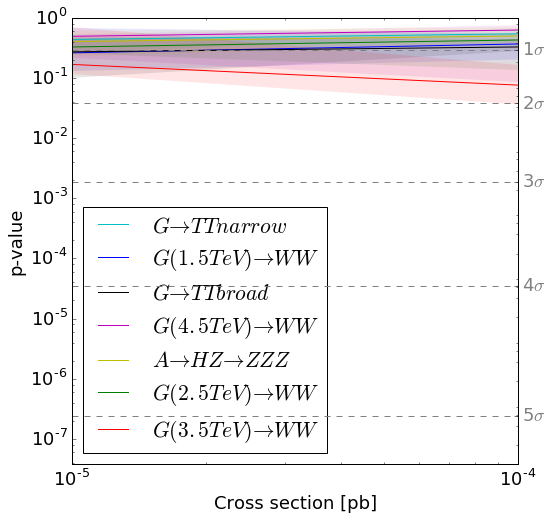

In [60]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax1 = plt.subplots(figsize=(8,8))

for n, val_aux in dic_p_val.iteritems():
    val_aux = np.array(val_aux)
    x_sec = val_aux[:, 0]
    quant = val_aux[:, 1:]
    
    ax1.plot(x_sec, quant[:, 2], color=sample_col[n], label=sample_label[n])
    print(x_sec, quant[:,2])
    ax1.fill_between(x_sec, quant[:, 1], quant[:, 3], color=sample_col[n], alpha = 0.1, lw=0)
#     ax1.fill_between(x_sec, quant[:, 0], quant[:, 4], color=sample_col[n], alpha = 0.1, lw=0)
    
    
plt.xscale('log')
plt.xlabel('Cross section [pb]')
plt.yscale('log')
plt.ylabel('p-value')
plt.ylim(1 - erf(5.5/np.sqrt(2)), 1)
plt.legend(loc='lower left')
ax2 = ax1.twinx()
for i in range(1, 6):
    p = 1 - erf(i/np.sqrt(2))
    ax2.plot([x_sec[0], x_sec[-1]], 2*[p], '--', color='grey')
plt.yscale('log')
ax2.set_yticks(1 - erf(np.arange(1,6)/np.sqrt(2)))
ax2.set_yticklabels(['{}$\sigma$'.format(i) for i in range(1,6)])
ax2.tick_params(axis='y', labelcolor='grey')

fig.savefig('fig/' + 'pValueScan_L' + str(lumi) + 'pb-1.png', bbox_inches='tight')